# Table of contents

1. **Minimal approach:** how to run the code to read the DFT data, define the optimal model, and calculate the model coefficients.
2. **Plot results:** how to read the code results and plot the bands.
3. **Verify set alpha:** alternative code to verify if the selection is correct.
4. **Verify convergence:** check how the coefficients change with the number of remote bands.

# Minimal approach

In this first section we run the minimal code as shown in the paper. 

**How to select set alpha?**

Here we avoid plotting figures to keep the code simple. So, to properly identify the set A (alpha), the user must plot the bands separatelly (via xmgrace, for instance) and identify the index of the relevant bands.

Alternativelly, the user can replace *step 3* with a more elaborated code shown in the section **Verify set alpha** below.

In [1]:
import numpy as np
import pydft2kp as dft2kp

In [2]:
%%capture
# avoid unecessary output from the irrep package

# step 1: read DFT data
kp = dft2kp.irrep(dftdir='CsPbCl3',
                  outdir='outdir',
                  prefix='CsPbCl3',
                  kpt=31,
                  kname='R')

# step 2: read or calculate matrix elements of p
kp.get_p_matrices(qekp='kp.dat')

In [3]:
# step 3: define the set alpha
#         applies fold down via Löwdin
setA = np.arange(42,50)
kp.define_set_A(setA)

Space group  221 : Pm-3m
Group of the k-vector: <code not ready>
Verifying set A: [42 43 44 45 46 47 48 49]
Band indices: [42, 43] Irreps: (-R6) Degeneracy: 2
Band indices: [44, 45] Irreps: (-R8) Degeneracy: 2
Band indices: [46, 47, 48, 49] Irreps: (-R11) Degeneracy: 4


In [4]:
# step 4: builds optimal model with qsymm
# s0, sx, sy, sz: Pauli matrices
from pydft2kp.constants import s0, sx, sy, sz
from scipy.linalg import expm

# IRREPS without SOC (A1g e T1u)
# Generators Oh: S6[1,1,1], C4z

# S6 and C4 built reps with a trick
# -----------------------------------------
# since the T1u basis is (x,y,z)
# we can use R from qsymm to build it
# and we can se U from qsymm with spin=1/2
# to get the spin representation

#---------------------------------
# S6 [1,1,1]: inv * C3
#---------------------------------
S6 = dft2kp.rotation(1/3, [1,1,1], True, spin=1/2)
spin = S6.U
orb = np.eye(4)
orb[1:, 1:] = S6.R
pU = np.kron(spin, orb)
S6 = dft2kp.rotation(1/3, [1,1,1], True, U=pU)

#---------------------------------
# C4z ----------------------------
#---------------------------------
C4 = dft2kp.rotation(1/4, [0,0,1], False, spin=1/2)
spin = C4.U
orb = np.eye(4)
orb[1:, 1:] = C4.R
pU = np.kron(spin, orb)
C4 = dft2kp.rotation(1/4, [0,0,1], False, U=pU)

#---------------------------------
# TRS ----------------------------
#---------------------------------
orb = np.kron(s0, s0)
spin = 1j*sy
pU = np.kron(spin, orb)
TRS = dft2kp.time_reversal(3, U = pU)

symms = [C4, S6, TRS]
qs = dft2kp.qsymm(symms, dim=3, total_power=2, prettify=True, print_model=True, summed=True);

Matrix([
[c0 + c7*k_x**2 + c7*k_y**2 + c7*k_z**2,                                             -c3*k_y + I*c4*k_x,                                              c3*k_x + I*c4*k_y,                                                      I*c4*k_z,                                      0,                                                     -I*c3*k_z,                                                        -c3*k_z,                                             I*c3*k_x + c3*k_y],
[                    -c3*k_y - I*c4*k_x,                        c1 + c10*k_x**2 + c8*k_y**2 + c8*k_z**2,  I*c11*k_x**2 + I*c11*k_y**2 - I*c2 + c6*k_x*k_y - I*c9*k_z**2,                                    -I*c5*k_y*k_z + c6*k_x*k_z,                              -I*c3*k_z,                                                             0,                                      I*c5*k_x*k_z + c5*k_y*k_z,      -c11*k_x**2 - c11*k_z**2 + c2 - I*c5*k_x*k_y + c9*k_y**2],
[                     c3*k_x - I*c4*k_y, -I*c11*k_x**2 - I*c11*k_

In [5]:
 # step 5: calculate the representation matrices for each symmetry operation
kp.get_symm_matrices();
# (optional): adds anti-unitary symmetry
kp.add_antiunitary_symm(TRS, np.array([0,0,0]))

In [7]:
# step 6: calculates and applies the transformation U
optimal = dft2kp.basis_transform(qs, kp)

# step 7: print results
optimal.print_report(sigdigits=3)

cn      a.u. (Ry, a0)    with (eV, nm)  units    k powers
----  ---------------  ---------------  -------  ----------
c0           -0.0321          -0.437    eV       0
c1            0.113            1.54     eV       0
c2            0.0405           0.552    eV       0
c3            0.00402          0.0029   eV.nm    x,y,z
c4           -0.749           -0.539    eV.nm    x,y,z
c5            0.192            0.00733  eV.nm²   xy,xz,yz
c6           -2.07            -0.0787   eV.nm²   xy,xz,yz
c7           -0.513           -0.0195   eV.nm²   xx,yy,zz
c8            1.29             0.0493   eV.nm²   xx,yy,zz
c9            0.0571           0.00217  eV.nm²   xx,yy,zz
c10           4.58             0.174    eV.nm²   xx,yy,zz
c11           0.176            0.00672  eV.nm²   xx,yy,zz


# Plot results

Once the model is complete, we can plot the bands.

Here the `qe_plotter(...)` is a helper to read the DFT bands in gnuplot format and organize the data to be plotted in python. It provides

- a helper routine `set_labels_and_limits(...)` to fix plot labels and k axis
- kdist: 1D array for the axis points properly spaced
- k3D: list of (kx,ky,kz) for each point in kdist

In [8]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

# kpath as run in the bands calculation of QE
kpath = [[    30,          30,      1], 
         [R'$\Gamma$', R'$R$', R'$X$']]

# init plotter
bands = dft2kp.qe_plotter(kp, 'bands.gnu', kpath)

In [9]:
# crude and optimal models as H(kx,ky,kz)

# build crude model with all bands
H_crude_full = kp.build_H_of_k(all_bands=True)
# build crude model folded into set A
H_crude_setA = kp.build_H_of_k(all_bands=False)

# the optimal model for set was already computed
# in step 6 above: optimal.Heff

# compute the eigenenergies as a function k for the path used in QE's data
Efull = np.array([np.linalg.eigvalsh(H_crude_full(*kvec)) for kvec in bands.k3D])
EsetA = np.array([np.linalg.eigvalsh(H_crude_setA(*kvec)) for kvec in bands.k3D])
Ek = np.array([np.linalg.eigvalsh(optimal.Heff(*kvec)) for kvec in bands.k3D])

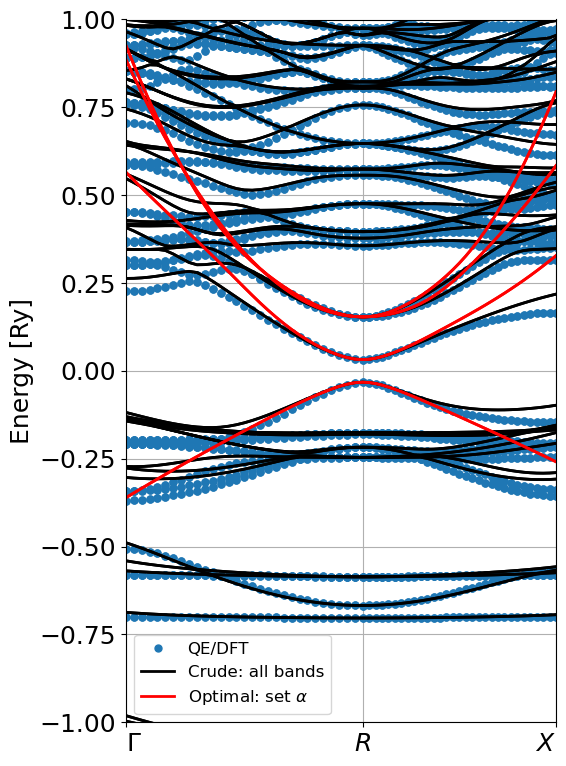

In [10]:
plt.figure(figsize=(6,8))
pdft   = plt.plot(bands.kdist, bands.bands, 'o', c='C0', ms=5) 
pcrude = plt.plot(bands.kdist, Efull, c='black', lw=2)
poptim = plt.plot(bands.kdist, Ek, c='red', lw=2)
# set legends for single lines
pdft[0].set_label('QE/DFT')
pcrude[0].set_label('Crude: all bands')
poptim[0].set_label(r'Optimal: set $\alpha$')
plt.legend(fontsize=12)
bands.set_labels_and_limits(ax=plt.gca(), ymin=-1, ymax=1)
plt.grid()

plt.tight_layout()
basename = 'Figures/' + kp.dftdir.replace('/', '')
plt.savefig(basename + '.svg')
plt.savefig(basename + '.png')
plt.show()

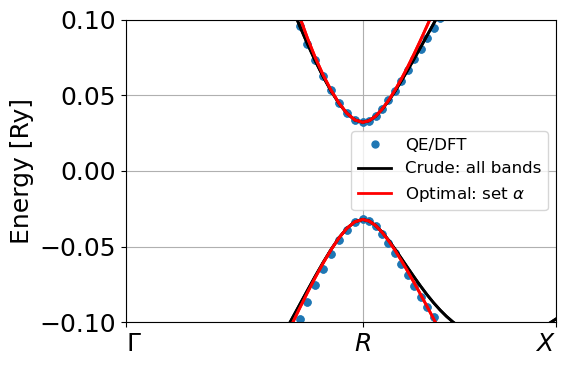

In [11]:
##############################################################
# ZOOM IN
##############################################################

plt.figure(figsize=(6,4))
pdft   = plt.plot(bands.kdist, bands.bands, 'o', c='C0', ms=5) 
pcrude = plt.plot(bands.kdist, Efull, c='black', lw=2)
poptim = plt.plot(bands.kdist, Ek, c='red', lw=2)
# set legends for single lines
pdft[0].set_label('QE/DFT')
pcrude[0].set_label('Crude: all bands')
poptim[0].set_label(r'Optimal: set $\alpha$')
plt.legend(fontsize=12)
bands.set_labels_and_limits(ax=plt.gca(), ymin=-0.1, ymax=0.1)#, xmin=-3*dft2kp.a0, xmax=3*dft2kp.a0)
plt.grid()

plt.tight_layout()
basename = 'Figures/' + kp.dftdir.replace('/', '')
plt.savefig(basename + '-zoom.svg')
plt.savefig(basename + '-zoom.png')
plt.show()

# Verify set alpha

If the user wants to verify if set A (alpha) was chosen correctly, it is useful to plot the DFT bands emphasizing the set A.

In this case, add this steps to step 3 above:

1. Init matplotlib and plotter if necessary. See Plot results section above.
2. Plot the bands and set follwing this example:

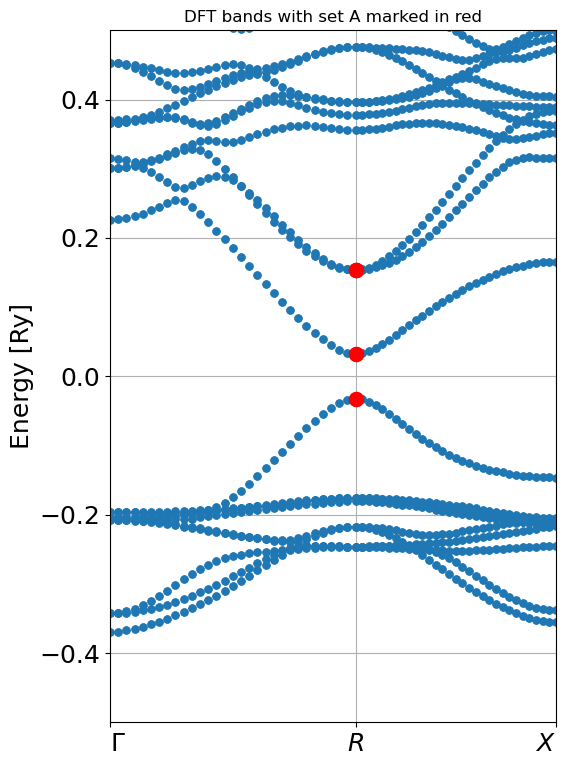

In [12]:
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 18})

plt.figure(figsize=(6,8))
plt.title('DFT bands with set A marked in red', fontsize=12)
plt.plot(bands.kdist, bands.bands, 'o', ms=5, c='C0') # DFT
# ----------------------
# Emphasize set A in red
plt.scatter([0]*len(setA), bands.en_at_k[setA], c='red', s=100, zorder=10)
# ----------------------
bands.set_labels_and_limits(ax=plt.gca(), ymin=-1/2, ymax=1/2)
plt.grid()
plt.tight_layout()
plt.show()

# Verify convergence

To verify the convergence of the parameter as a function of the number of bands, one can redo the folding down with a reduced number of remote bands and plot how the coefficients change as a function of the number of remote bands.

In [13]:
nbands = len(kp.energies)
NBs = np.arange(0, nbands - setA[-1], 1)
cns = []
for NB in NBs:
    # redo fold down using only NB remote bands
    kp.fold_down_H(NB=NB)
    # identify and store list of coefficients
    cns += [list(optimal.getHeff(qs, kp)[0])]
cns = np.array(cns)

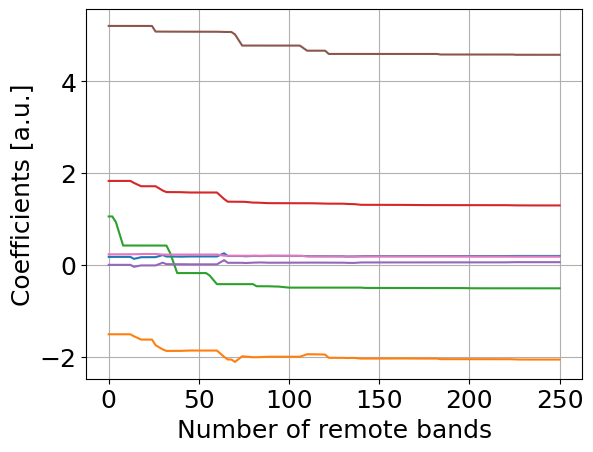

In [15]:
for n in range(cns.shape[1]):
    # only k² or larger powers depend on number of remote bands
    if set(optimal.keys[n]) & set([0, 'x','y','z']):
        continue
    plt.plot(NBs, cns[:,n], label=optimal.keys[n])
# plt.legend(fontsize=10)
plt.xlabel('Number of remote bands')
plt.ylabel(r'Coefficients [a.u.]')
plt.grid()
plt.show()